# Metropolis-Hastings Algorithm

### Purpose:
A mechanism to sample from the posterior distribution of a random variable.   
Posterior $\propto$ Prior $\times$ Likelihood  
$P(\theta|x) \propto P(x)P(x|\theta)$

In [1]:
#rc('font',**{'family':'sans-serif','sans-serif':['Computer Modern Sans serif']})
## for Palatino and other serif fonts use:
import matplotlib as mpl
mpl.rc("savefig", dpi=100)
mpl.rc('font',**{'family':'serif','serif':['Palatino']})
mpl.rc('text', usetex=True)


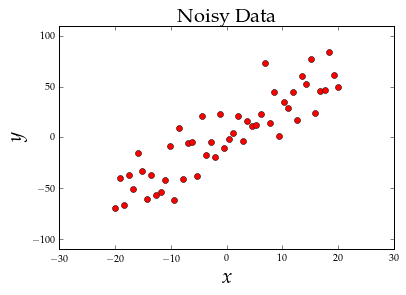

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(-20,20,50)
noise = 20*np.random.randn(50,) # sigma = 15
a,b = 3,0
y = a*x+b+noise
# plot
plt.plot(x,y,'ro')
plt.ylim(ymin=-110,ymax=110)
plt.xlim(xmin = -30,xmax = 30)
plt.xlabel('$x$',fontsize=20)
plt.ylabel('$y$',fontsize=20)

plt.title('Noisy Data',fontsize=20)

18.4854094735 [ 3.05492729  2.44520151]


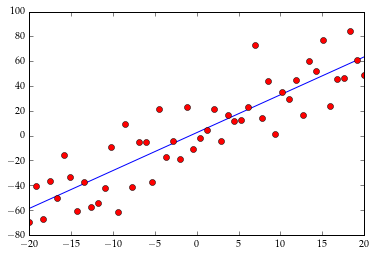

In [3]:
# estimated sigma of y-dist
## Fit a straight line to the data; take sigma of y-pred
pp = np.polyfit(x,y,1)
pred = pp[0]*x+pp[1]
plt.plot(x,pred,x,y,'ro')#,fillstyle='none')
ysig = np.std(y - pred)
print ysig,pp

In [4]:

import scipy.stats as ss

# Log Likelihood Function
def log_likelihood(params,x,y):
    a=params[0] # using estimated slope
    b=params[1] # estimated intercept
    sig = params[2] # estimated sigma of y
    
    ypred = a*x+b
    yll = ss.norm.logpdf(y,loc=ypred,scale = sig) 
    suml = np.sum(yll)
    return(suml)

# Prior
def log_prior(params):        
    a_pr = ss.uniform.logpdf(params[0],loc=0,scale=10)
    b_pr = ss.norm.logpdf(params[1],loc=0,scale=5)
    sig_pr = ss.uniform.logpdf(params[2],loc=0,scale=30)
    lprior = a_pr+b_pr+sig_pr
    return(lprior)

# Posterior = Prior X Likelihood/ Normalizing_Constant
def log_posterior(params,x,y):   
    lpost = log_likelihood(params,x,y) + log_prior(params)    
    return(lpost)


(-928.24301009656301, -173.67262559540734)

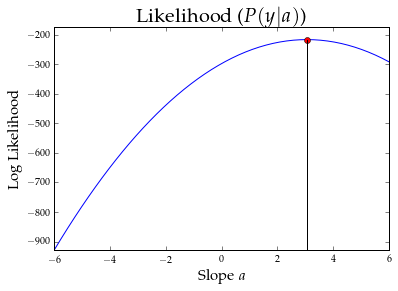

In [5]:
# A sample of what the likelihood function looks like
sample_as = np.linspace(-6,6,50)

y_log_likelihood = [log_likelihood([ax,pp[1],20],x,y) for ax in sample_as]
in_mx = np.argmax(y_log_likelihood)
plt.plot(sample_as,y_log_likelihood,sample_as[in_mx],y_log_likelihood[in_mx],'ro')
plt.plot([sample_as[in_mx],sample_as[in_mx]],[1.2*min(y_log_likelihood),y_log_likelihood[in_mx]],'k')
plt.title('Likelihood ($P(y|a)$)',fontsize=20)
plt.xlabel('Slope $a$',fontsize=15)
plt.ylabel('Log Likelihood',fontsize=15)
plt.ylim(ymin=min(y_log_likelihood),ymax = max(y_log_likelihood)*0.8)
#plt.figure(figsize= (30,30))

## Detailed Balance
We assume that the probability distribution of the parameter is stationary.
Now assume that there is a Markov process that allows us to transition from one value $\theta_i$ to $\theta_j$, both of which belong to the stationary distribution $\pi(\theta)$.
Then we have,  
$\pi(\theta_i)P(\theta_j|\theta_i) = \pi(\theta_j)P(\theta_i|\theta_j)$  
This equation is called the **detailed balance equation**. 

However, if we pick some transition probability then we might find that   
$\pi(\theta_i)P(\theta_j|\theta_i) > \pi(\theta_j)P(\theta_i|\theta_j)$  
then we can achieve *Detailed Balance* by adding a term $\alpha$ such that  
$\pi(\theta_i)P(\theta_j|\theta_i) \times \alpha =  \pi(\theta_j)P(\theta_i|\theta_j)$   

$\alpha =  \frac{\pi(\theta_j)P(\theta_i|\theta_j)}{\pi(\theta_i)P(\theta_j|\theta_i)}$  

If $\alpha<1$ then we transition to $\theta_j$ else we stay at $\theta_i$. Here $P$ is called *proposal distribution*.


In [6]:
# The Metropolis Hastings Algorithm
# We shall sample from the posterior to get robust estimate 
# of the parameters

def proposal(params):
    rv1 = ss.norm.rvs(loc = params[0] ,scale = 0.1)
    rv2 = ss.norm.rvs(loc = params[1], scale = 0.5)
    rv3 = ss.norm.rvs(loc = params[2], scale = .3)
    return([rv1,rv2,rv3])


# init_val initial guess
# N = Number of iterations
def metro_hastings(init_val,N,x,y):    
    mc = np.empty([N,3]) # markov chain
    mc[0,:]= init_val
    ac = np.empty([N-1])
    pc = np.empty([N-1])
    
    for i in range(N-1):
        prps = proposal(mc[i,:]) # proposed random sample
        #if log_prior(prps)==-float("inf"):
        #    print log_prior(prps),prps
        alpha = np.exp(log_posterior(prps,x,y) - log_posterior(mc[i,:],x,y))
        
        #if i%500==0:
        #    print alpha,prps,log_posterior(prps,x,y)
        if alpha > ss.uniform.rvs():
            mc[i+1,:] = prps
            ac[i] = alpha
            pc[i] = log_posterior(prps,x,y) - log_posterior(mc[i,:],x,y)
        else:
            mc[i+1,:] = mc[i,:]
            ac[i]= ac[i-1]   
            pc[i]=0
    return(mc,ac,pc) 



In [7]:
init_value = [7,10,10]
mc,ac,pc=metro_hastings(init_value,20000,x,y)

In [8]:
# Estimate of alpha (acceptance ratio)
transient=10000
est_alpha = float(len(np.unique(mc[transient:,1])))/len(mc[transient:,1])
print est_alpha*100,'%'

81.38 %


The Estimated Parameters are: 
[  3.06402022   2.3020643   19.51745786]


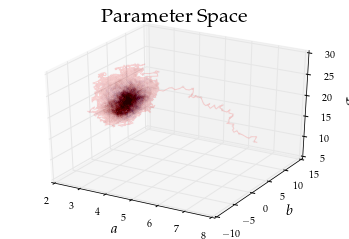

In [9]:
#%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(mc[:20000,0],mc[:20000,1],mc[:20000,2],c='r',alpha=0.15)
#ax.plot(mc[15001:20000,0],mc[15001:20000,1],mc[15001:20000,2],c='b',alpha=0.1)
ax.scatter(mc[:15000,0],mc[:15000,1],mc[:15000,2],marker='.',c='r',alpha=0.005)
ax.scatter(mc[15001:20000,0],mc[15001:20000,1],mc[15001:20000,2],marker='.',c='b',alpha=0.005)
mest = np.mean(mc[-5000:,:],0)
ax.scatter(mest[0],mest[1],mest[2],c='g',marker='o')
ax.set_xlabel('$a$',fontsize=15)
ax.set_ylabel('$b$',fontsize=15)
ax.set_zlabel('$\sigma$',fontsize=15)
ax.set_title('Parameter Space',fontsize=20)
print 'The Estimated Parameters are: \n',np.mean(mc[-5000:,:],0)


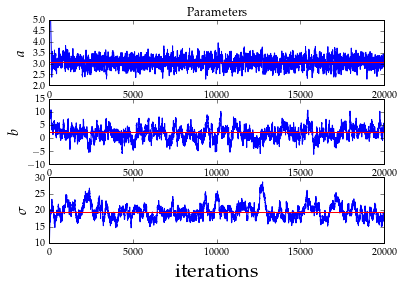

In [10]:
fig = plt.figure()
fig.add_subplot(3,1,1)
plt.plot(range(20000),mc[:20000,0])
plt.plot([0,20000],[mest[0],mest[0]],'r')
plt.ylabel('$a$',fontsize=15)
plt.ylim(ymax=5)
plt.title('Parameters')
fig.add_subplot(312)
plt.plot(range(20000),mc[:20000,1])
plt.plot([0,20000],[mest[1],mest[1]],'r')
plt.ylabel('$b$',fontsize=15)
fig.add_subplot(313)
plt.plot(range(20000),mc[:20000,2])
plt.plot([0,20000],[mest[2],mest[2]],'r')
plt.ylabel('$\sigma$',fontsize=15)
plt.xlabel('iterations',fontsize=20)

In [11]:
%qtconsole

Red Lines show means: [  3.06402022   2.3020643   19.51745786]


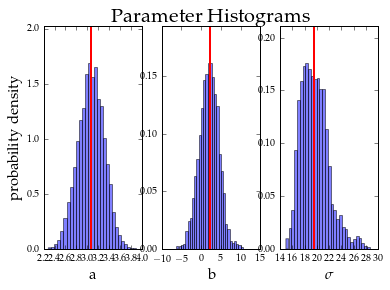

In [12]:
fig = plt.figure()
figsize= (20,10)
fig.add_subplot(1,3,1)
n, bins, patches = plt.hist(mc[10000:,0], 30, normed=1, facecolor='b', alpha=0.5)
plt.plot([mest[0],mest[0]],[0,max(n)*1.2],'r',linewidth=2)
plt.xlabel('a',fontsize=15)
plt.ylabel('probability density',fontsize=15)
plt.ylim(ymax=max(n)*1.2)

fig.add_subplot(1,3,2)
n, bins, patches = plt.hist(mc[10000:,1], 30, normed=1, facecolor='b', alpha=0.5)
plt.plot([mest[1],mest[1]],[0,max(n)*1.2],'r',linewidth=2)
plt.xlabel('b',fontsize=15)
plt.ylim(ymax=max(n)*1.2)
plt.title('Parameter Histograms',fontsize=20)

fig.add_subplot(1,3,3)
n, bins, patches = plt.hist(mc[10000:,2], 30, normed=1, facecolor='b', alpha=0.5)
plt.plot([mest[2],mest[2]],[0,max(n)*1.2],'r',linewidth=2)
plt.xlabel('$\sigma$',fontsize=15)
plt.ylim(ymax=max(n)*1.2)

print 'Red Lines show means:', mest